In [1]:
import numpy as np

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

sns.set_style('whitegrid')
%matplotlib inline

In [4]:
import os
import datetime

In [7]:
DATA_FOLDER = r'data'
DRIVER_FILE = os.path.join(DATA_FOLDER, 'driver_ids.csv')
RIDE_FILE = os.path.join(DATA_FOLDER, 'ride_ids.csv')
EVENT_FILE = os.path.join(DATA_FOLDER, 'ride_timestamps.csv')

#### Fare Assumptions

In [67]:
BASE_FARE = 2.00
COST_PER_MILE = 1.15
COST_PER_MINUTE = 0.22
SERVICE_FEE = 1.75
MINIMUM_FARE = 5.00
MAXIMUM_FARE = 400.00

COST_PER_METER = COST_PER_MILE / 1609.34
COST_PER_SECOND = COST_PER_MINUTE / 60.0

PRIME_SURCHARGE = 0.2

#### Load the Data

In [82]:
df_driver = pd.read_csv(DRIVER_FILE)
df_ride = pd.read_csv(RIDE_FILE)
df_event = pd.read_csv(EVENT_FILE)

In [83]:
df_driver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 2 columns):
driver_id              937 non-null object
driver_onboard_date    937 non-null object
dtypes: object(2)
memory usage: 14.7+ KB


In [84]:
df_driver.head()

,driver_id,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29 00:00:00
1,007f0389f9c7b03ef97098422f902e62,2016-03-29 00:00:00
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05 00:00:00
3,0152a2f305e71d26cc964f8d4411add9,2016-04-23 00:00:00
4,01674381af7edd264113d4e6ed55ecda,2016-04-29 00:00:00


In [85]:
df_ride.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193502 entries, 0 to 193501
Data columns (total 5 columns):
driver_id          193502 non-null object
ride_id            193502 non-null object
ride_distance      193502 non-null int64
ride_duration      193502 non-null int64
ride_prime_time    193502 non-null int64
dtypes: int64(3), object(2)
memory usage: 7.4+ MB


In [86]:
df_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970405 entries, 0 to 970404
Data columns (total 3 columns):
ride_id      970405 non-null object
event        970405 non-null object
timestamp    970404 non-null object
dtypes: object(3)
memory usage: 22.2+ MB


In [87]:
df_event.head()

,ride_id,event,timestamp
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05


#### Data Transformation and Cleaning

In [88]:
df_driver['driver_onboard_date'] = pd.to_datetime(df_driver.driver_onboard_date, infer_datetime_format=True, utc=True)

In [89]:
df_event['timestamp'] = pd.to_datetime(df_event.timestamp, infer_datetime_format=True, utc=True)

In [90]:
df_ride.describe()

,ride_distance,ride_duration,ride_prime_time
count,193502.000000,193502.000000,193502.000000
mean,6955.218266,858.966099,17.305893
std,8929.444606,571.375818,30.825800
min,-2.000000,2.000000,0.000000
25%,2459.000000,491.000000,0.000000
50%,4015.000000,727.000000,0.000000
75%,7193.000000,1069.000000,25.000000
max,724679.000000,28204.000000,500.000000


In [91]:
df_ride.iloc[df_ride.ride_duration.idxmax()]

driver_id          02d6a6b8a6da15fc219a9570f7ebbe78
ride_id            e7f8524051edb7b28e86391f6461bc03
ride_distance                                724679
ride_duration                                 28204
ride_prime_time                                   0
Name: 1921, dtype: object

#### EDA

##### For each driver, how many rides did they complete?

In [92]:
df_driver_features = df_driver.copy()

In [93]:
df_driver_features.set_index('driver_id', inplace=True)
df_driver_features['rides'] = df_ride.groupby('driver_id')['ride_id'].count().rename(columns={'ride_id':'rides'})

In [94]:
df_driver_features['rides'].fillna(0, inplace=True)

In [95]:
df_driver_features.describe()

,rides
count,937.000000
mean,198.389541
std,180.197182
min,0.000000
25%,39.000000
50%,200.000000
75%,316.000000
max,919.000000


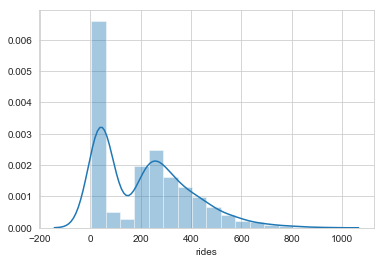

In [96]:
sns.distplot(df_driver_features.loc[df_driver_features.rides>0, 'rides'])

#### Compute the fare for each ride

In [97]:
def fare(df):
    f = BASE_FARE + df.ride_distance * COST_PER_METER + df.ride_duration*COST_PER_SECOND + df.ride_prime_time*PRIME_SURCHARGE + SERVICE_FEE
    df['fare'] = np.minimum(np.maximum(MINIMUM_FARE, f), MAXIMUM_FARE)

In [98]:
fare(df_ride)

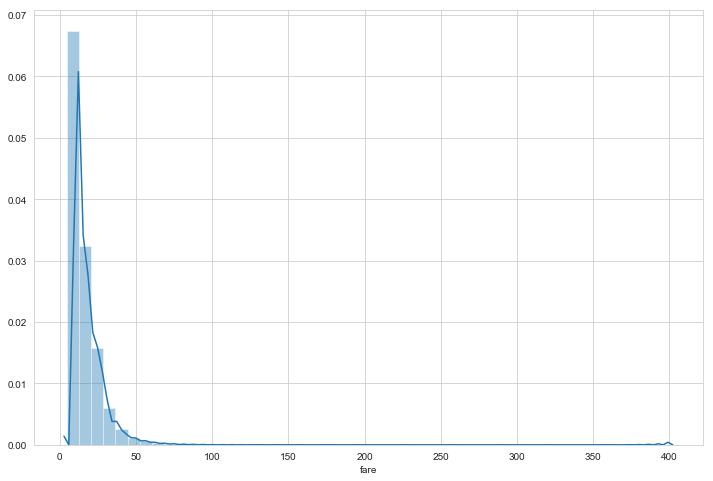

In [99]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.distplot(df_ride.fare, ax=ax)

In [100]:
df_driver_features['total_fare'] = df_ride.groupby('driver_id')['fare'].sum()
df_driver_features['total_fare'].fillna(0, inplace=True)

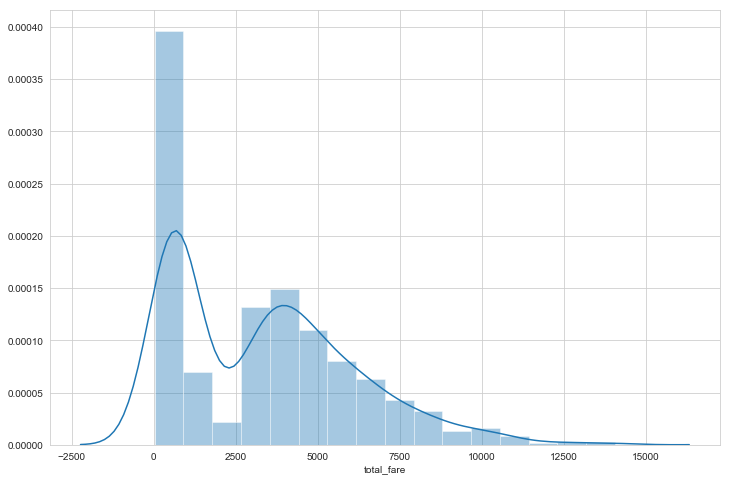

In [101]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.distplot(df_driver_features.loc[df_driver_features.rides>0, 'total_fare'], ax=ax)

In [102]:
df_driver_features.loc[df_driver_features.rides>0, 'total_fare'].describe()

count      854.000000
mean      3337.784374
std       2747.048895
min         25.691325
25%        684.329135
50%       3324.648226
75%       5031.578018
max      14061.226649
Name: total_fare, dtype: float64

#### What is the total active duration of each driver? From onboard to the last accepted ride

In [103]:
df_event.timestamp.min(), df_event.timestamp.max()

(Timestamp('2016-03-28 05:48:18+0000', tz='UTC'),
 Timestamp('2016-06-27 00:50:50+0000', tz='UTC'))

In [104]:
df_driver_features.driver_onboard_date.min(), df_driver_features.driver_onboard_date.max()

(Timestamp('2016-03-28 00:00:00+0000', tz='UTC'),
 Timestamp('2016-05-15 00:00:00+0000', tz='UTC'))

In [110]:
df_event_wide = df_event.pivot(index='ride_id', 
                               columns='event', values='timestamp').loc[:, ['requested_at', 'accepted_at', 
                                                                            'arrived_at', 'picked_up_at', 
                                                                            'dropped_off_at']].reset_index()
df_event_wide.head()

event,ride_id,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at
0,00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:19,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 09:44:33,2016-06-13 10:03:05
1,00005eae40882760d675da5effb89ae3,2016-05-14 05:23:21,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:26:18,2016-05-14 05:34:17
2,000061d42cf29f73b591041d9a1b2973,2016-05-16 15:43:09,2016-05-16 15:43:14,2016-05-16 15:47:29,2016-05-16 15:47:32,2016-05-16 15:54:18
3,00006efeb0d5e3ccad7d921ddeee9900,2016-05-11 19:29:36,2016-05-11 19:29:43,2016-05-11 19:35:11,2016-05-11 19:35:15,2016-05-11 19:40:47
4,0000d9b24d8ccdd991b76258e616fa01,2016-04-26 18:11:38,2016-04-26 18:12:15,2016-04-26 18:16:52,2016-04-26 18:16:55,2016-04-26 18:24:14


In [122]:
df_event_wide['accepted_at'].dt.dayofweek

0         0
1         5
2         0
3         2
4         1
5         1
6         6
7         5
8         3
9         6
10        5
11        4
12        0
13        1
14        0
15        5
16        1
17        1
18        6
19        4
20        5
21        4
22        2
23        1
24        2
25        1
26        1
27        6
28        1
29        0
         ..
194051    4
194052    4
194053    3
194054    6
194055    5
194056    3
194057    2
194058    4
194059    5
194060    4
194061    1
194062    0
194063    1
194064    3
194065    4
194066    3
194067    4
194068    3
194069    6
194070    3
194071    4
194072    5
194073    3
194074    2
194075    1
194076    3
194077    4
194078    6
194079    1
194080    2
Name: accepted_at, Length: 194081, dtype: int64